In [1]:
import pandas as pd

df = pd.read_csv('games.csv')

# Remove duplicate games
df = df.drop_duplicates(subset=['id'])

# Remove unnecessary attributes
df = df.drop(columns=['id', 'created_at', 'last_move_at', 'white_id', 'black_id', 'opening_name', 'opening_ply'])

# Remove unrated games
df = df[df['rated'] != False]

# Remove games with less than 5 turns
df = df[df['turns'] >= 5]

# Remove games that ended in a draw or an out of time
df = df[df['victory_status'] != 'outoftime']
df = df[df['victory_status'] != 'draw']

# Remove games with time settings that are faster than 5+0
for index, row in df.iterrows():
    minute = int(row['increment_code'].split("+")[0])
    if (minute < 5):
        df = df.drop(index = index)
        
# Create 'game_speed' attribute
game_speed = []
for index, row in df.iterrows():
    minute = int(row['increment_code'].split("+")[0])
    if (minute < 10):
        game_speed.append('Blitz')
    elif (minute < 30):
        game_speed.append('Rapid')
    else:
        game_speed.append('Classical')
df['game_speed'] = game_speed

# Replace the entire opening eco with just the first letter
for index, row in df.iterrows():
    df.at[index, 'opening_eco'] = row['opening_eco'][0]
    
# Create 'average_rating' and 'rating_difference' attributes
rating_difference = []
average_rating = []
for index, row in df.iterrows():
    rating_difference.append(row['white_rating'] - row['black_rating'])
    average_rating.append((row['white_rating'] + row['black_rating']) / 2)
df['rating_difference'] = rating_difference
df['average_rating'] = average_rating

# Remove more attributes
df = df.drop(columns = ['white_rating', 'black_rating', 'rated', 'increment_code'])

In [2]:
def get_turns_to_unique(p, c, n):
    """
    Input:
    p - A string representing the previous game's moves
    c - A string representing the current game's moves
    n - A string representing the next game's moves
    """
    
    if (p is None):
        p = ""
        
    if (n is None):
        n = ""
        
    prevMoves = p.split()
    currMoves = c.split()
    nextMoves = n.split()
    
    i = 0
    j = 0
    
    while (i < len(prevMoves) and i < len(currMoves) and currMoves[i] == prevMoves[i] ): 
        i += 1 
           
    while (j < len(nextMoves) and j < len(currMoves) and currMoves[j] == nextMoves[j]):
        j += 1
        
    if (i > j):
        return i
    else:
        return j

# Create 'turns_to_unique' attribute
df.sort_values(by=['moves'], inplace=True)

s = df['moves']

turns_to_unique = []
unique_by_white = []

for i in range(df.shape[0]):
    p = None
    if i > 0:
        p = s.iloc[i-1]
    
    n = None
    if i < df.shape[0] - 1:
        n = s.iloc[i+1]
        
    c = s.iloc[i]
        
    moves = get_turns_to_unique(p, c, n)
        
    turns_to_unique.append(moves)
    
    if moves % 2 == 0:
        unique_by_white.append(True)
    else:
        unique_by_white.append(False)
    
df['turns_to_unique'] = turns_to_unique
df['unique_by_white'] = unique_by_white

df = df.drop(columns = 'moves')
df

,turns,victory_status,winner,opening_eco,game_speed,rating_difference,average_rating,turns_to_unique,unique_by_white
3899,30,mate,black,A,Rapid,132,1376.0,0,True
9479,85,mate,white,A,Rapid,64,1829.0,2,True
11119,69,mate,white,A,Rapid,-53,1559.5,2,True
6121,28,mate,black,A,Rapid,279,1570.5,2,True
2762,96,resign,black,D,Rapid,454,1439.0,4,True
9480,31,resign,white,C,Rapid,19,1814.5,4,True
14737,53,resign,white,A,Rapid,-11,1765.5,3,False
14608,128,mate,black,A,Blitz,-342,1448.0,2,True
10034,12,mate,black,A,Rapid,-306,1403.0,2,True
7259,93,resign,white,A,Blitz,200,1587.0,2,True


## Imports

In [3]:
# imports for evaluation
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from statistics import mean
import numpy as np


pd.options.mode.chained_assignment = None

## Modeling for Baseline

In [4]:
# creating test and training data for baseline model
df_x_base = df.iloc[:,[0, 3, 4, 5, 6]]
df_y_base = df.iloc[:, 2]

df_x_new = df.iloc[:,[0, 3, 4, 5, 6, 7, 8]]
df_y_new = df.iloc[:, 2]

x_base_train, x_base_test, y_base_train, y_base_test = train_test_split(df_x_base, df_y_base, random_state=5)
print(x_base_train.head())

       turns opening_eco game_speed  rating_difference  average_rating
19525     31           B      Blitz                -72          2042.0
15152     19           B      Rapid                -54          1438.0
2280      70           A      Rapid               -179          2046.5
18475     78           A      Rapid                -68          1818.0
4734      68           C      Rapid                 37          1502.5


In [5]:
# process strings into ints
le = LabelEncoder()

le.fit(x_base_train.loc[:,"opening_eco"].astype(str))
x_base_train.loc[:,"opening_eco"] = le.transform(x_base_train.loc[:,"opening_eco"].astype(str))
x_base_test.loc[:,"opening_eco"] = le.transform(x_base_test.loc[:,"opening_eco"].astype(str))

le.fit(x_base_train.loc[:,"game_speed"].astype(str))
x_base_train.loc[:,"game_speed"] = le.transform(x_base_train.loc[:,"game_speed"].astype(str))
x_base_test.loc[:,"game_speed"] = le.transform(x_base_test.loc[:,"game_speed"].astype(str))

In [6]:
# decision tree baseline
dt_base = DecisionTreeClassifier(random_state=0)
path = dt_base.cost_complexity_pruning_path(x_base_train, y_base_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs Effective Alpha for Training Set')

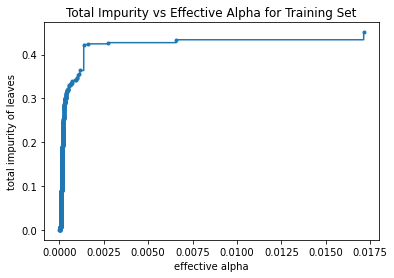

In [7]:
# plots total impurity vs effective alpha
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker=".", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for Training Set")

In [8]:
dts_base = []
for ccp_alpha in ccp_alphas:
    dt_base = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt_base.fit(x_base_train, y_base_train)
    dts_base.append(dt_base)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(dts_base[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.047771008481214294


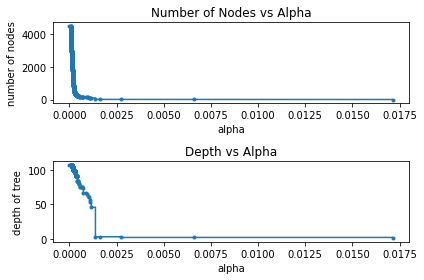

In [9]:
dts_base = dts_base[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [dt_base.tree_.node_count for dt_base in dts_base]
depth = [dt_base.tree_.max_depth for dt_base in dts_base]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker=".", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of Nodes vs Alpha")
ax[1].plot(ccp_alphas, depth, marker=".", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs Alpha")
fig.tight_layout()

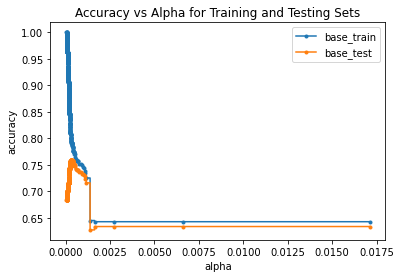

In [10]:
base_train_scores = [dt_base.score(x_base_train, y_base_train) for dt_base in dts_base]
base_test_scores = [dt_base.score(x_base_test, y_base_test) for dt_base in dts_base]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs Alpha for Training and Testing Sets")
ax.plot(ccp_alphas, base_train_scores, marker=".", label="base_train", drawstyle="steps-post")
ax.plot(ccp_alphas, base_test_scores, marker=".", label="base_test", drawstyle="steps-post")
ax.legend()
plt.show()

In [11]:
print("Accuracy: {}".format(max(base_test_scores)))
print("Alpha: {}".format(ccp_alphas[base_test_scores.index(max(base_test_scores))]))

Accuracy: 0.7593323216995448
Alpha: 0.000310309306649608


In [12]:
dt_base = DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608)
dt_base.fit(x_base_train, y_base_train)
print("Testing Score: {}".format(dt_base.score(x_base_test, y_base_test)))
print("Training Score: {}".format(dt_base.score(x_base_train, y_base_train)))

Testing Score: 0.7593323216995448
Training Score: 0.7977130135600081


In [13]:
total_scores = []

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), n_estimators=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_10 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
total_scores.append(scores_10)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), n_estimators=50)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_50 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
total_scores.append(scores_50)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_100 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
total_scores.append(scores_100)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), n_estimators=500)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_500 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
total_scores.append(scores_500)


In [14]:
model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), n_estimators=1000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_1000 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
total_scores.append(scores_1000)

In [15]:
model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), n_estimators=5000)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_5000 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
total_scores.append(scores_5000)

In [16]:
mean_scores = []
for score in total_scores:
    mean = np.mean(score)
    mean_scores.append(mean)
print(mean_scores)

[0.7430677397390184, 0.7587859845616217, 0.7621927231940006, 0.7637441000806443, 0.7637103618890111, 0.7638794963218889]


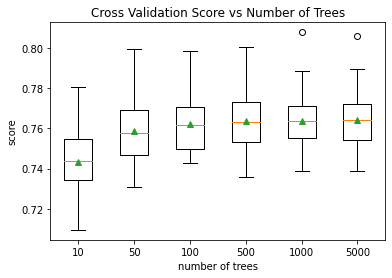

In [17]:
names = ["10", "50", "100", "500", "1000", "5000"]
fig, ax = plt.subplots()
ax.set_xlabel("number of trees")
ax.set_ylabel("score")
ax.set_title("Cross Validation Score vs Number of Trees")
ax.boxplot(total_scores, labels=names, showmeans=True)
plt.show()

In [18]:
samples_score = []

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_1 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_1)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_2 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_2)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.3)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_3 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_3)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_4 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_4)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.5)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_5 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_5)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.6)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_6 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_6)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.7)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_7 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_7)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.8)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_8 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_8)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=0.9)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_0_9 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_0_9)

model_base = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                               n_estimators=100, max_samples=1.0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
scores_1_0 = cross_val_score(model_base, x_base_train, y_base_train, scoring="accuracy", cv=cv, n_jobs=-1)
samples_score.append(scores_1_0)

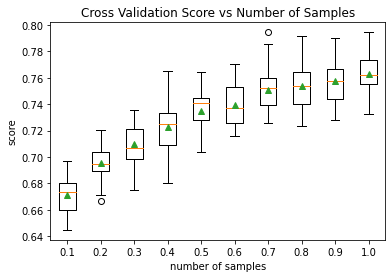

In [19]:
samples = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
fig, ax = plt.subplots()
ax.set_xlabel("number of samples")
ax.set_ylabel("score")
ax.set_title("Cross Validation Score vs Number of Samples")
ax.boxplot(samples_score, labels=samples, showmeans=True)
plt.show()

In [20]:
# Final Baseline Classifier
bg = BaggingClassifier(DecisionTreeClassifier(random_state=0, ccp_alpha=0.000310309306649608), 
                       max_samples = 1.0, n_estimators = 100)
bg.fit(x_base_train, y_base_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.000310309306649608,
                                                        random_state=0),
                  n_estimators=100)

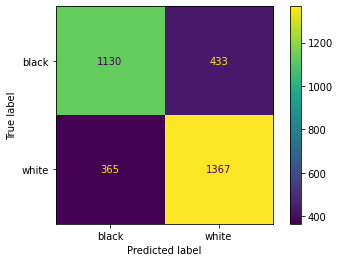

In [21]:
# Comparison to initial decision tree classifier
y_base_test_pred = bg.predict(x_base_test)
bg_matrix = confusion_matrix(y_base_test, y_base_test_pred)
plot = plot_confusion_matrix(bg, x_base_test, y_base_test)

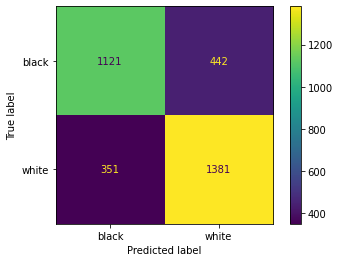

In [22]:
plot_basic = plot_confusion_matrix(dt_base, x_base_test, y_base_test)

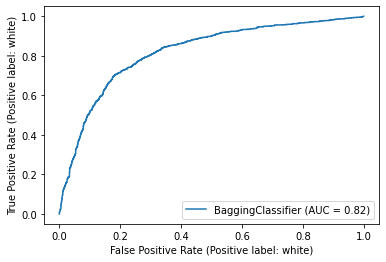

In [23]:
plot_roc = plot_roc_curve(bg, x_base_test, y_base_test)

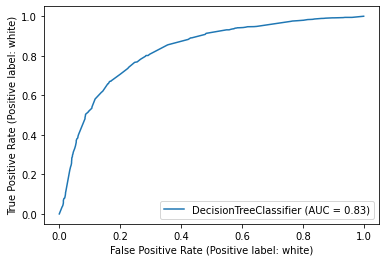

In [24]:
plot_roc = plot_roc_curve(dt_base, x_base_test, y_base_test)